# Modeling
### goals
* develop a model that effectively predicts 2019 AQI pollution levels
* implement pipeline
* implement feature selection and visualizations in modeling

## Import packages

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn import preprocessing, svm
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error

#Use to ignore convergence warnings
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import __version__ as sklearn_version
import datetime

import joblib

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=FitFailedWarning)


# pd.set_option('display.max_columns', None)
# pd.reset_option('max_rows')
# np.set_printoptions(threshold=sys.maxsize)

plt.style.use('dark_background')
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
sns.set(style='ticks', context='talk')

## Load X and y data sets

In [2]:
# import X and y training and test sets

X = pd.read_csv('../../data/train_test/X_alt')
y = pd.read_csv('../../data/train_test/y_alt')

X_train = pd.read_csv('../../data/train_test/X_train_74_26')

X_test = pd.read_csv('../../data/train_test/X_test_74_26')

y_train = pd.read_csv('../../data/train_test/y_train_alt_74_26')

y_test = pd.read_csv('../../data/train_test/y_test_alt+74_26')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.26, random_state=42)

## Develop baseline with dummy regressor
* Run Dummy Regressor with strategy mean and median

#### Dummy Regressor with Mean Strategy
* cross validate with X_train and y_train
* score on X_test and y_test

In [ ]:
# Using Mean Strategy
dummy_mean = DummyRegressor(strategy='mean')
dummy_mean_r2 = cross_validate(dummy_mean, X_train, y_train, scoring='r2', cv=5, n_jobs=-1)
dummy_mae = cross_validate(dummy_mean, X_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
dummy_mean.fit(X_train, y_train)

In [249]:
dummy_mean_train_score = np.mean(dummy_mean_r2['test_score'])
dummy_mean_train_std = np.std(dummy_mean_r2['test_score'])
dummy_mean_test_score = r2_score(y_test, dummy_mean.predict(X_test))

dummy_mean_mae = np.mean(dummy_mae['test_score'])
dummy_mean_mae_std = np.std(dummy_mae['test_score'])
dummy_mean_mae_test = mean_absolute_error(y_test, dummy_mean.predict(X_test))

In [250]:
print('Train MAE mean:', dummy_mean_mae, 'CV Train Std', dummy_mean_mae_std)
print('Test MAE mean:', dummy_mean_mae_test)
print('\n')
print('Train R^2:', dummy_mean_train_score, 'Train std', dummy_mean_train_std)
print('Test R^2:', dummy_mean_test_score)

Train MAE mean: -2.859319876514479 CV Train Std 0.4915346089757947
Test MAE mean: 4.224395075447405


Train R^2: -0.01988083053185279 Train std 0.015606963641777855
Test R^2: -0.014683484428373195


#### Dummy Regressor with Median Strategy
* cross validate with X_train and y_train
* score on X_test and y_test

In [257]:
# Using Median Strategy
dummy_median = DummyRegressor(strategy='median')
dummy_median_r2 = cross_validate(dummy_median, X_train, y_train, scoring='r2', cv=5, n_jobs=-1)
dummy_mae = cross_validate(dummy_median, X_train, y_train, scoring='neg_median_absolute_error', cv=5, n_jobs=-1)
dummy_median.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [258]:
dummy_median_train_score = np.mean(dummy_median_r2['test_score'])
dummy_median_train_std = np.std(dummy_median_r2['test_score'])
dummy_median_test_score = r2_score(y_test, dummy_median.predict(X_test))

dummy_median_mae = np.mean(dummy_mae['test_score'])
dummy_median_mae_std = np.std(dummy_mae['test_score'])
dummy_median_mae_test = mean_absolute_error(y_test, dummy_median.predict(X_test))

In [259]:
print('Train MAE mean:', dummy_median_mae, 'CV Train Std', dummy_median_mae_std)
print('Test MAE mean:', dummy_median_mae_test)
print('\n')
print('Train R^2:', dummy_median_train_score, 'Train std', dummy_median_train_std)
print('Test R^2:', dummy_median_test_score)


Train MAE mean: -2.859319876514479 CV Train Std 0.4915346089757947
Test MAE mean: 3.965553703522264


Train R^2: -0.05634349921670236 Train std 0.0770498421567673
Test R^2: -0.005731197263146637


## Linear Regression Model


In [144]:
lr_pipe = Pipeline([('scaler', StandardScaler()),
                 ('select_best', SelectKBest(f_regression)),
                 ('lr', LinearRegression())])

In [145]:
# run to get adjustable parameters of pipeline
lr_pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('select_best',
   SelectKBest(score_func=<function f_regression at 0x7f27f2b99550>)),
  ('lr', LinearRegression())],
 'verbose': False,
 'scaler': StandardScaler(),
 'select_best': SelectKBest(score_func=<function f_regression at 0x7f27f2b99550>),
 'lr': LinearRegression(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'select_best__k': 10,
 'select_best__score_func': <function sklearn.feature_selection._univariate_selection.f_regression(X, y, *, center=True)>,
 'lr__copy_X': True,
 'lr__fit_intercept': True,
 'lr__n_jobs': None,
 'lr__normalize': False,
 'lr__positive': False}

In [147]:
k = np.arange(1,X_train.shape[1] + 1).tolist()
lr_param_grid = {'select_best__k': k}

lr_grid = GridSearchCV(lr_pipe, lr_param_grid, cv=5)
lr_grid.fit(X_train, y_train)
lr_grid.best_score_

0.26496610736212933

In [94]:
print('best score', lr_grid.best_score_, 'best params', lr_grid.best_params_)


best score 0.26496610736212933 best params {'select_best__k': 3}


In [148]:
lr_score_mean = lr_grid.cv_results_['mean_test_score']
lr_score_std = lr_grid.cv_results_['std_test_score']

In [149]:
lr_cv_k = [k for k in lr_grid.cv_results_['param_select_best__k']]
lr_best_k = lr_grid.best_params_['select_best__k']


### Graph relationship between number of k_best features and mean cross validated scores

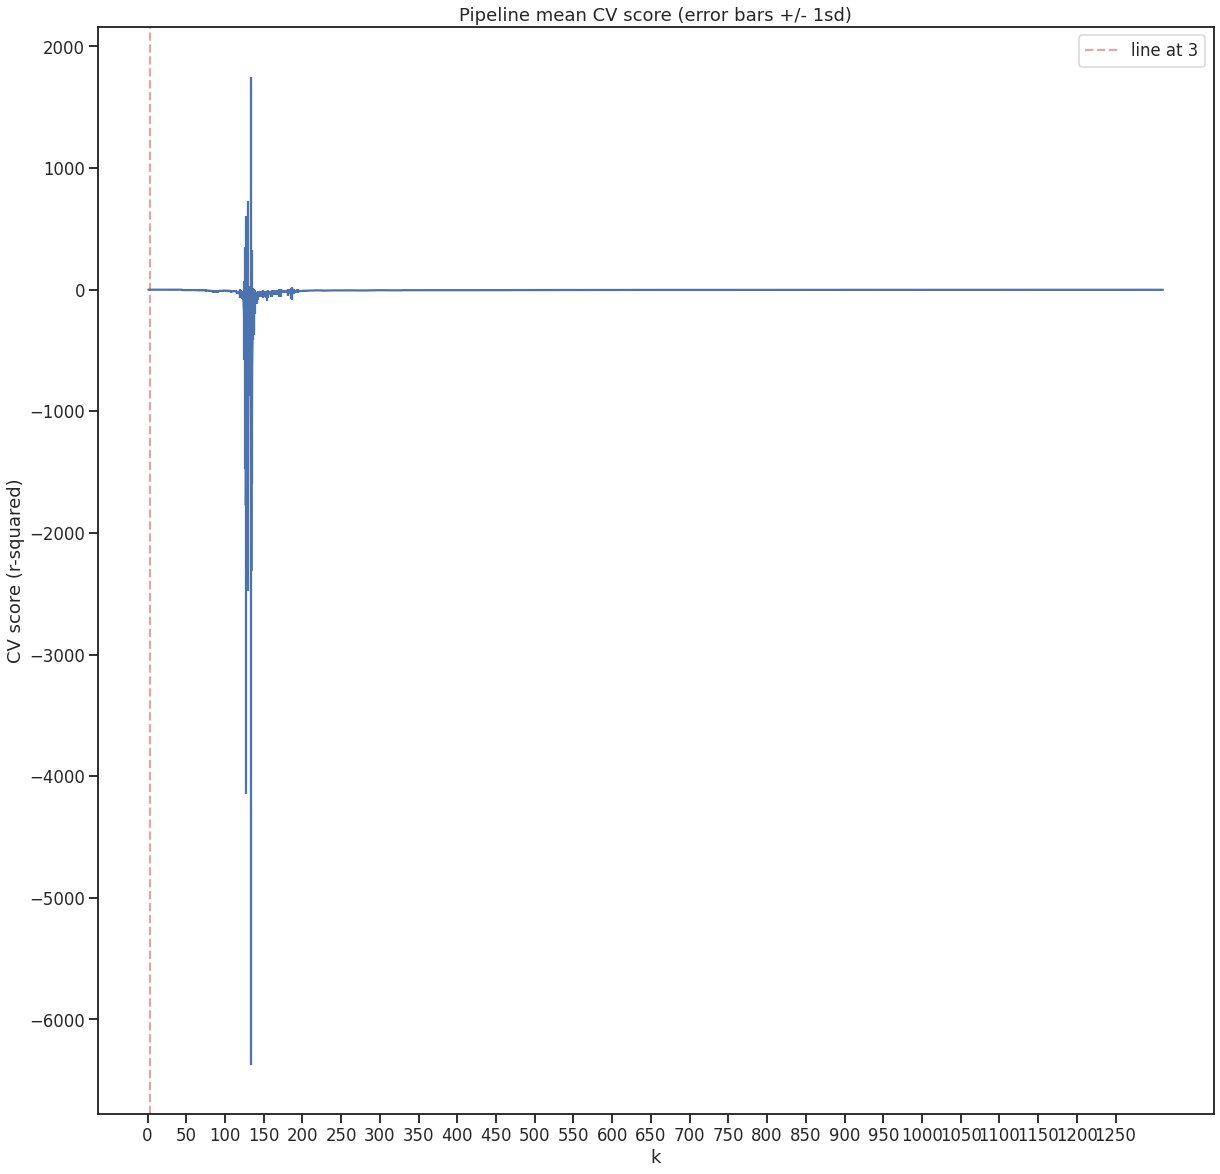

In [181]:
# graph k value with associated mean test score

#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
plt.subplots(figsize=(20, 20))
plt.errorbar(lr_cv_k, lr_score_mean, yerr=lr_score_std)
plt.axvline(x=lr_best_k, c='r', ls='--', alpha=.5, label='line at 3')
plt.xticks(np.arange(0,1300, step=50))
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')
plt.legend();
plt.savefig('../../data/plots/linear_regression_k_best.png')

### Evaluation of graph
It can be seen that within range 0-100 and 250-1300 k best features, the variation is approximately the same.
We can seee that at range 100 - 250 k best features, the variation spikes exponentially

### Zoomed (range 100) of graph

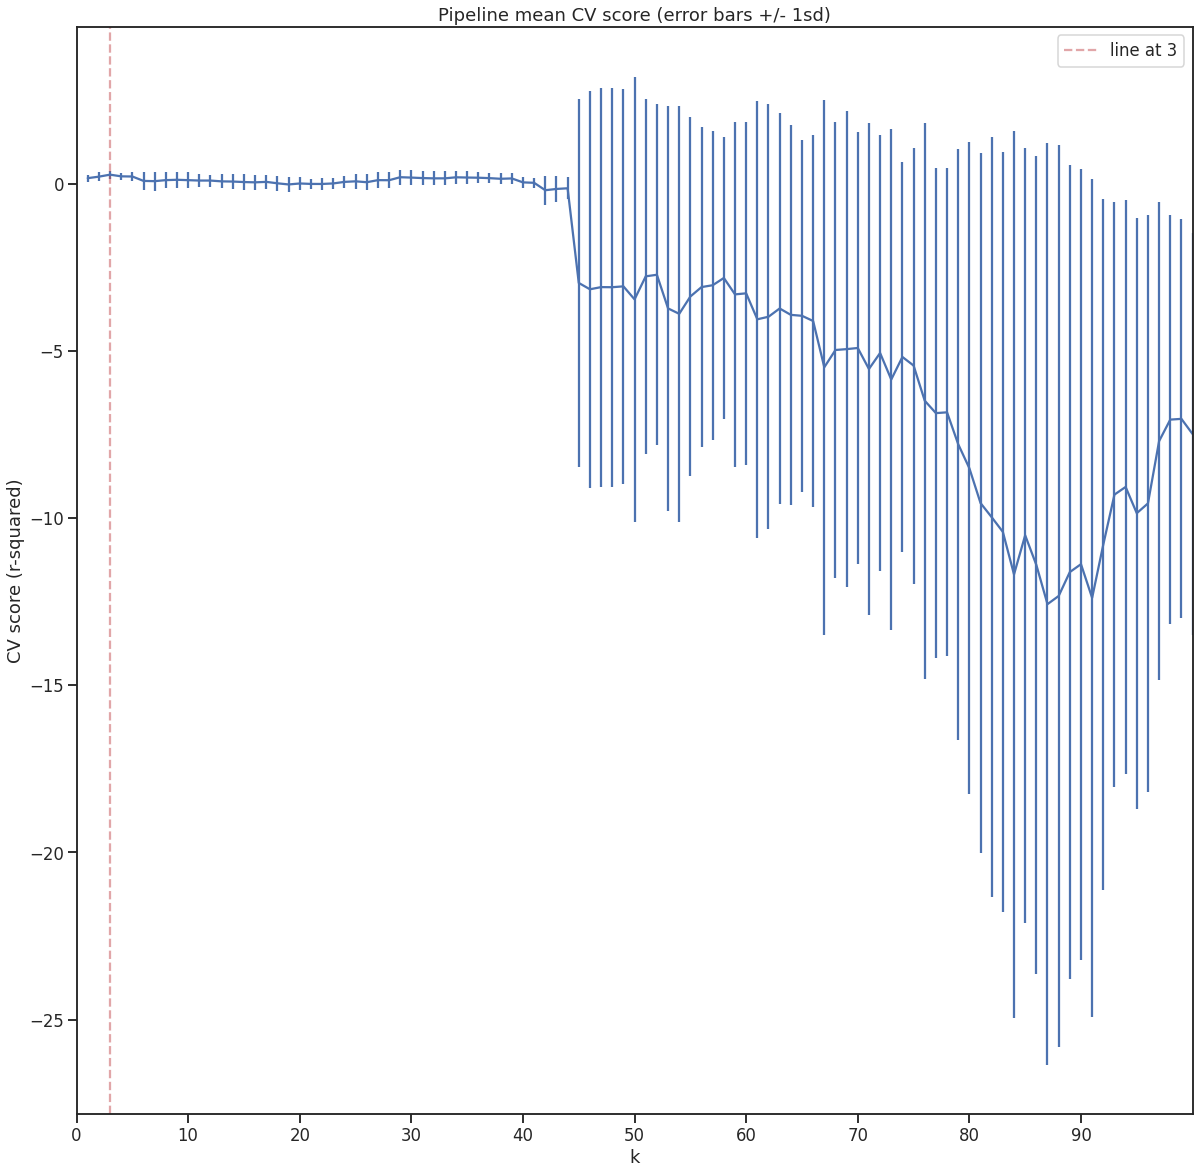

In [183]:
# zoomed in
plt.subplots(figsize=(20, 20))
plt.errorbar(lr_cv_k[:100], lr_score_mean[:100], yerr=lr_score_std[:100])
plt.axvline(x=lr_best_k, c='r', ls='--', alpha=.5, label='line at 3')
plt.xlim(0, 100)
plt.xticks(np.arange(0,100, step=10))
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')
plt.legend();
plt.savefig('../../data/plots/linear_regression_k_best_zoom_100.png', bbox_inches='tight')

### Evaluation of graph
We can see that the variation and score makes a large dip after 40 k best features

In [151]:
# retrieve the best coefficients from linear regression

k_best_features = lr_grid.best_estimator_.named_steps.select_best.get_support()
coefs = lr_grid.best_estimator_.named_steps.lr.coef_.tolist()[0]
lr_features = X_train.columns[k_best_features]
pd.Series(coefs, index=lr_features).sort_values(ascending=False)

HWAC_MALE_ratio_2018    17.546961
HWA_MALE_ratio_2018     -3.238566
H_MALE_ratio_2018      -11.785481
dtype: float64

In [155]:
lr_best_mean = lr_grid.cv_results_['mean_test_score'][lr_grid.best_index_]
lr_best_std = lr_grid.cv_results_['std_test_score'][lr_grid.best_index_]
print('best mean', lr_best_mean, 'best std', lr_best_std)

best mean 0.26496610736212933 best std 0.11753944354754035


In [156]:
# score with this linear regression model

best_lr_pipe = lr_grid.best_estimator_
best_lr_pipe.fit(X_train, y_train)
best_lr_pipe.score(X_test, y_test)

0.4063704301457888

For linear regression the top 3 features used are HWAC_MALE_ratio_2018,
HWA_MALE_ratio_2018, and H_MALE_ratio_2018.
Using this model we score .4 on our test set.
And this test score is within 2 standard deviation from our trained mean which means it is likely result

### linear regression model performance

In [158]:
# get mean absolute error from our best estimator and std dev on training

lr_neg_mae = cross_validate(lr_grid.best_estimator_, X_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=1)
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
print(lr_mae_mean, lr_mae_std)

3.524905303808373 0.47942535483907917


In [159]:
# get mean absolute error from test set
lr_mae_test_mean = mean_absolute_error(y_test, lr_grid.best_estimator_.predict(X_test))
lr_mae_test_mean

3.1819736651067734

## Random Forest Regressor Model


In [5]:
rf_pipe = Pipeline([('scaler', StandardScaler()),
                    ('rf', RandomForestRegressor(random_state=42))])


In [5]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('rf', RandomForestRegressor(random_state=42))],
 'verbose': False,
 'scaler': StandardScaler(),
 'rf': RandomForestRegressor(random_state=42),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'mse',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': 42,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [8]:
rf_param_grid = {
        'rf__n_estimators': [1000],
        'scaler': [StandardScaler(), None],
        'rf__criterion': ['mse', 'mae'],
}

In [9]:
# try running with select estimators and random forest insteawd
rf_grid = RandomizedSearchCV(rf_pipe, param_distributions=rf_param_grid, cv=5, n_jobs=-1)
rf_grid.fit(X_train, y_train)

/home/wkc/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('rf',
                                              RandomForestRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'rf__criterion': ['mse', 'mae'],
                                        'rf__n_estimators': [1000],
                                        'scaler': [StandardScaler(), None]},
                   random_state=42)

In [11]:
rf_grid.best_score_

0.2653864689058124

In [15]:
rf_grid.best_params_

{'scaler': None, 'rf__n_estimators': 1000, 'rf__criterion': 'mae'}

In [32]:
feat_importances = rf_grid.best_estimator_.named_steps.rf.feature_importances_
rf_feat_importances = pd.Series(feat_importances, index=X_train.columns).sort_values(ascending=False)
rf_feat_importances.head(20)

HAA_MALE_ratio_2018_2019_diff                                  0.019650
HAA_MALE_ratio_2017_2019_diff                                  0.018604
HWA_MALE_ratio_2018                                            0.015376
HBAC_FEMALE_ratio_2017_2018_diff                               0.014691
NH_FEMALE_ratio_2018                                           0.013332
HBAC_FEMALE_ratio_2017_2019_diff                               0.011383
HS_TOT_2017_2018_pct_change                                    0.009840
BACH_TOT_2017_2019_diff                                        0.009788
HWAC_FEMALE_ratio_2017_2019_pct_change                         0.008340
GRAD_TOT_ratio_2018                                            0.008240
NHIA_FEMALE_ratio_2017_2018_pct_change                         0.007916
NH_FEMALE_ratio_2017_2019_pct_change                           0.007862
HWAC_MALE_ratio_2018                                           0.006618
HS_TOT_ratio_2017_2018_pct_change                              0

In [25]:
print(rf_grid.cv_results_['mean_test_score'][rf_grid.best_index_], rf_grid.cv_results_['std_test_score'][rf_grid.best_index_])
print('mean', 'std')

(0.2653864689058124, 0.1515902486506784)

## Run with grid search
* previous run was with randomized grid search to narrow down parameters needed to tune
* should have set a random state for RandomizedGrid so results would be reproducible for randomized grid

In [29]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]

rf_param_grid = {
        'rf__n_estimators': n_est,
        'scaler': [StandardScaler(), None],
        'rf__criterion': ['mse', 'mae']
}

In [7]:
rf_grid_cv = GridSearchCV(rf_pipe, param_grid=rf_param_grid, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['mae'], 'rf__n_estimators': [69],
                         'scaler': [None]})

In [12]:
rf_grid_cv.best_score_, rf_grid_cv.cv_results_['std_test_score'][rf_grid_cv.best_index_], rf_grid_cv.best_params_

(0.2879457411778487,
 0.1506202031809065,
 {'rf__criterion': 'mae', 'rf__n_estimators': 69, 'scaler': None})

In [9]:
rf_mean_score = rf_grid_cv.cv_results_['mean_test_score']
rf_std_score = rf_grid_cv.cv_results_['mean_test_score']
rf_n_estimators_for_grid = [n for n in rf_grid_cv.cv_results_['param_rf__n_estimators']]
rf_best_n_estimator = rf_grid_cv.best_params_['rf__n_estimators']

### Graph relationship between n_estimators and mean Cross Validated scores


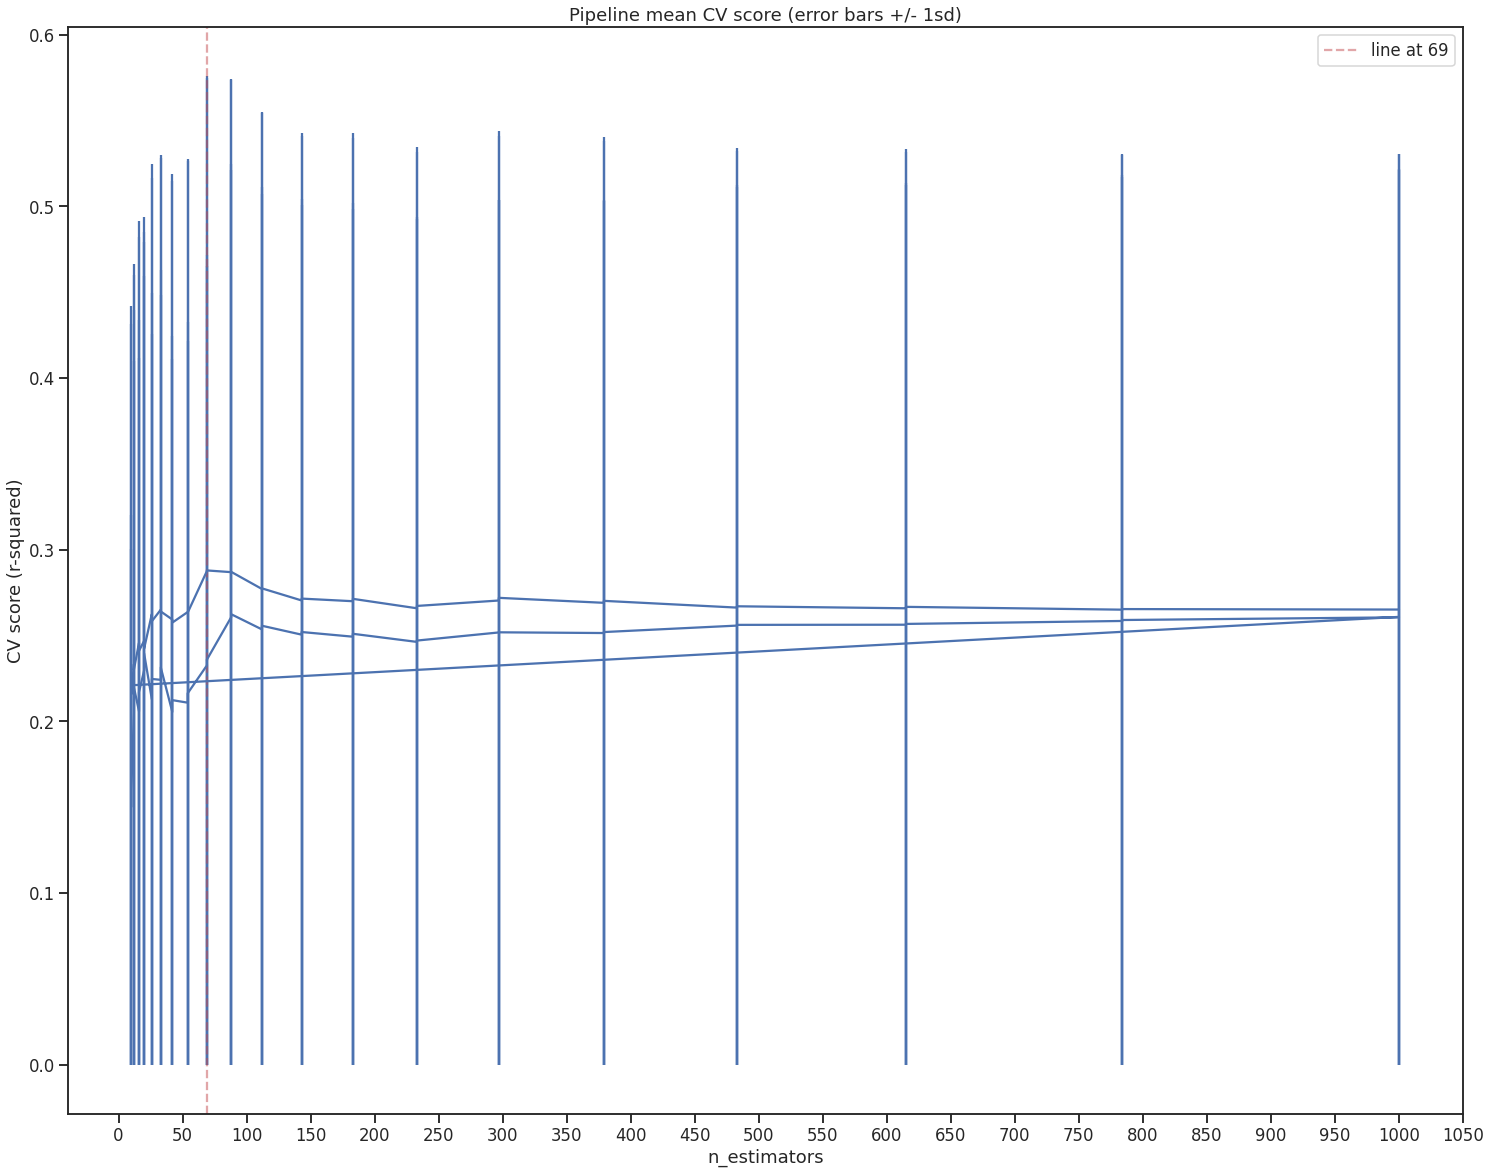

In [58]:
plt.subplots(figsize=(25, 20))
plt.errorbar(rf_n_estimators_for_grid, rf_mean_score, yerr=rf_std_score)
plt.axvline(x=rf_best_n_estimator, c='r', ls='--', alpha=.5, label='line at 69')
plt.xticks(np.arange(0,1100, step=50))
plt.xlabel('n_estimators')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')
plt.legend();

### Evaluation of graph
It appears that after 70 estimators our mean score decreases and stagnates at 300 estimators
It also appears that the variance at 69 estimators is very high and less variablility can be seen at
around 10 estimators.

### Zoomed (range 200) of graph

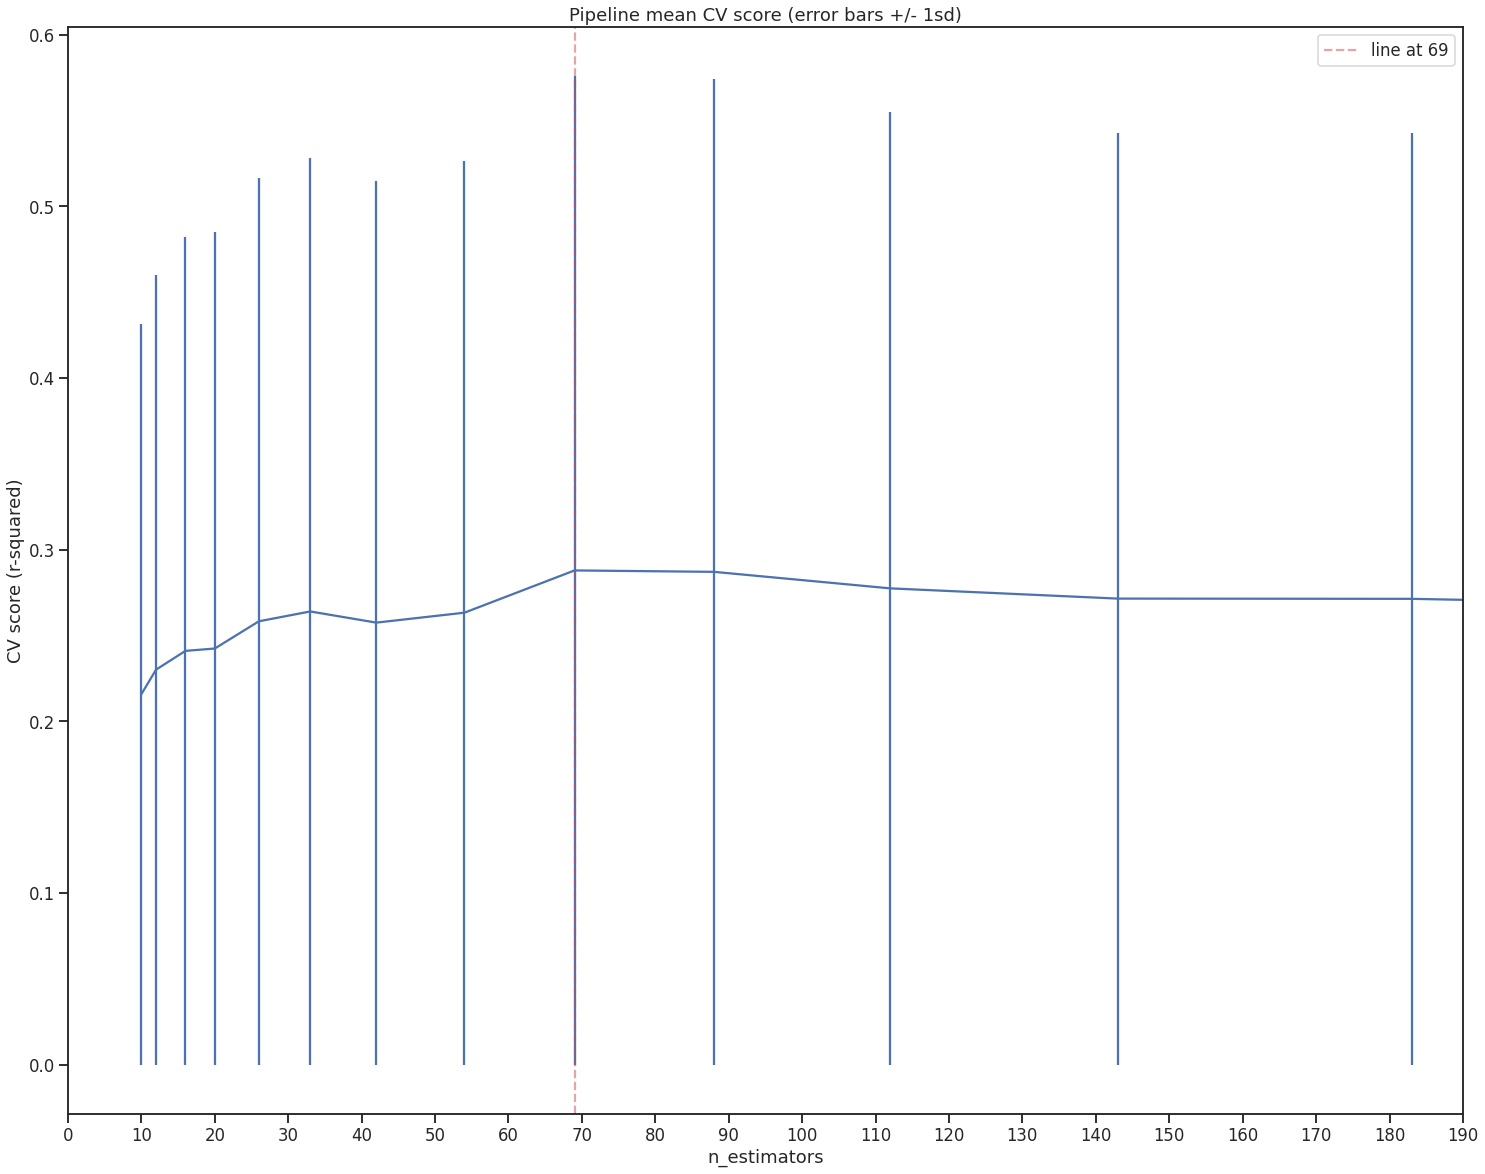

In [19]:
# zoomed in
plt.subplots(figsize=(25, 20))
plt.errorbar(rf_n_estimators_for_grid[:100], rf_mean_score[:100], yerr=rf_std_score[:100])
plt.axvline(x=rf_best_n_estimator, c='r', ls='--', alpha=.5, label='line at 69')
plt.xlim(0, 100)
plt.xticks(np.arange(0,200, step=10))
plt.xlabel('n_estimators')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')
plt.legend();

### Evaluation
From a zoomed perspective,variance spikes after 50 estimators at 69, and
it appears that estimators after 69 show no improvment and we see a decline

In [13]:
# look at feawture importance
feat_importances = rf_grid_cv.best_estimator_.named_steps.rf.feature_importances_
rf_feat_imp = pd.Series(feat_importances, index=X_train.columns).sort_values(ascending=False)
rf_feat_imp.head(10)

HBAC_FEMALE_ratio_2017_2018_diff    0.021064
NH_FEMALE_ratio_2018                0.020616
HAA_MALE_ratio_2018_2019_diff       0.017405
HWAC_MALE_ratio_2018                0.014636
HAA_MALE_ratio_2017_2019_diff       0.012532
BACH_TOT_2017_2019_diff             0.011422
HWA_MALE_ratio_2018                 0.011146
HAA_MALE_2018_2019_diff             0.010718
HBAC_FEMALE_ratio_2017_2019_diff    0.009172
GRAD_TOT_ratio_2018                 0.008567
dtype: float64

### Graph feature importances of Random Forest Regressor Model (top 100 features)

<AxesSubplot:>

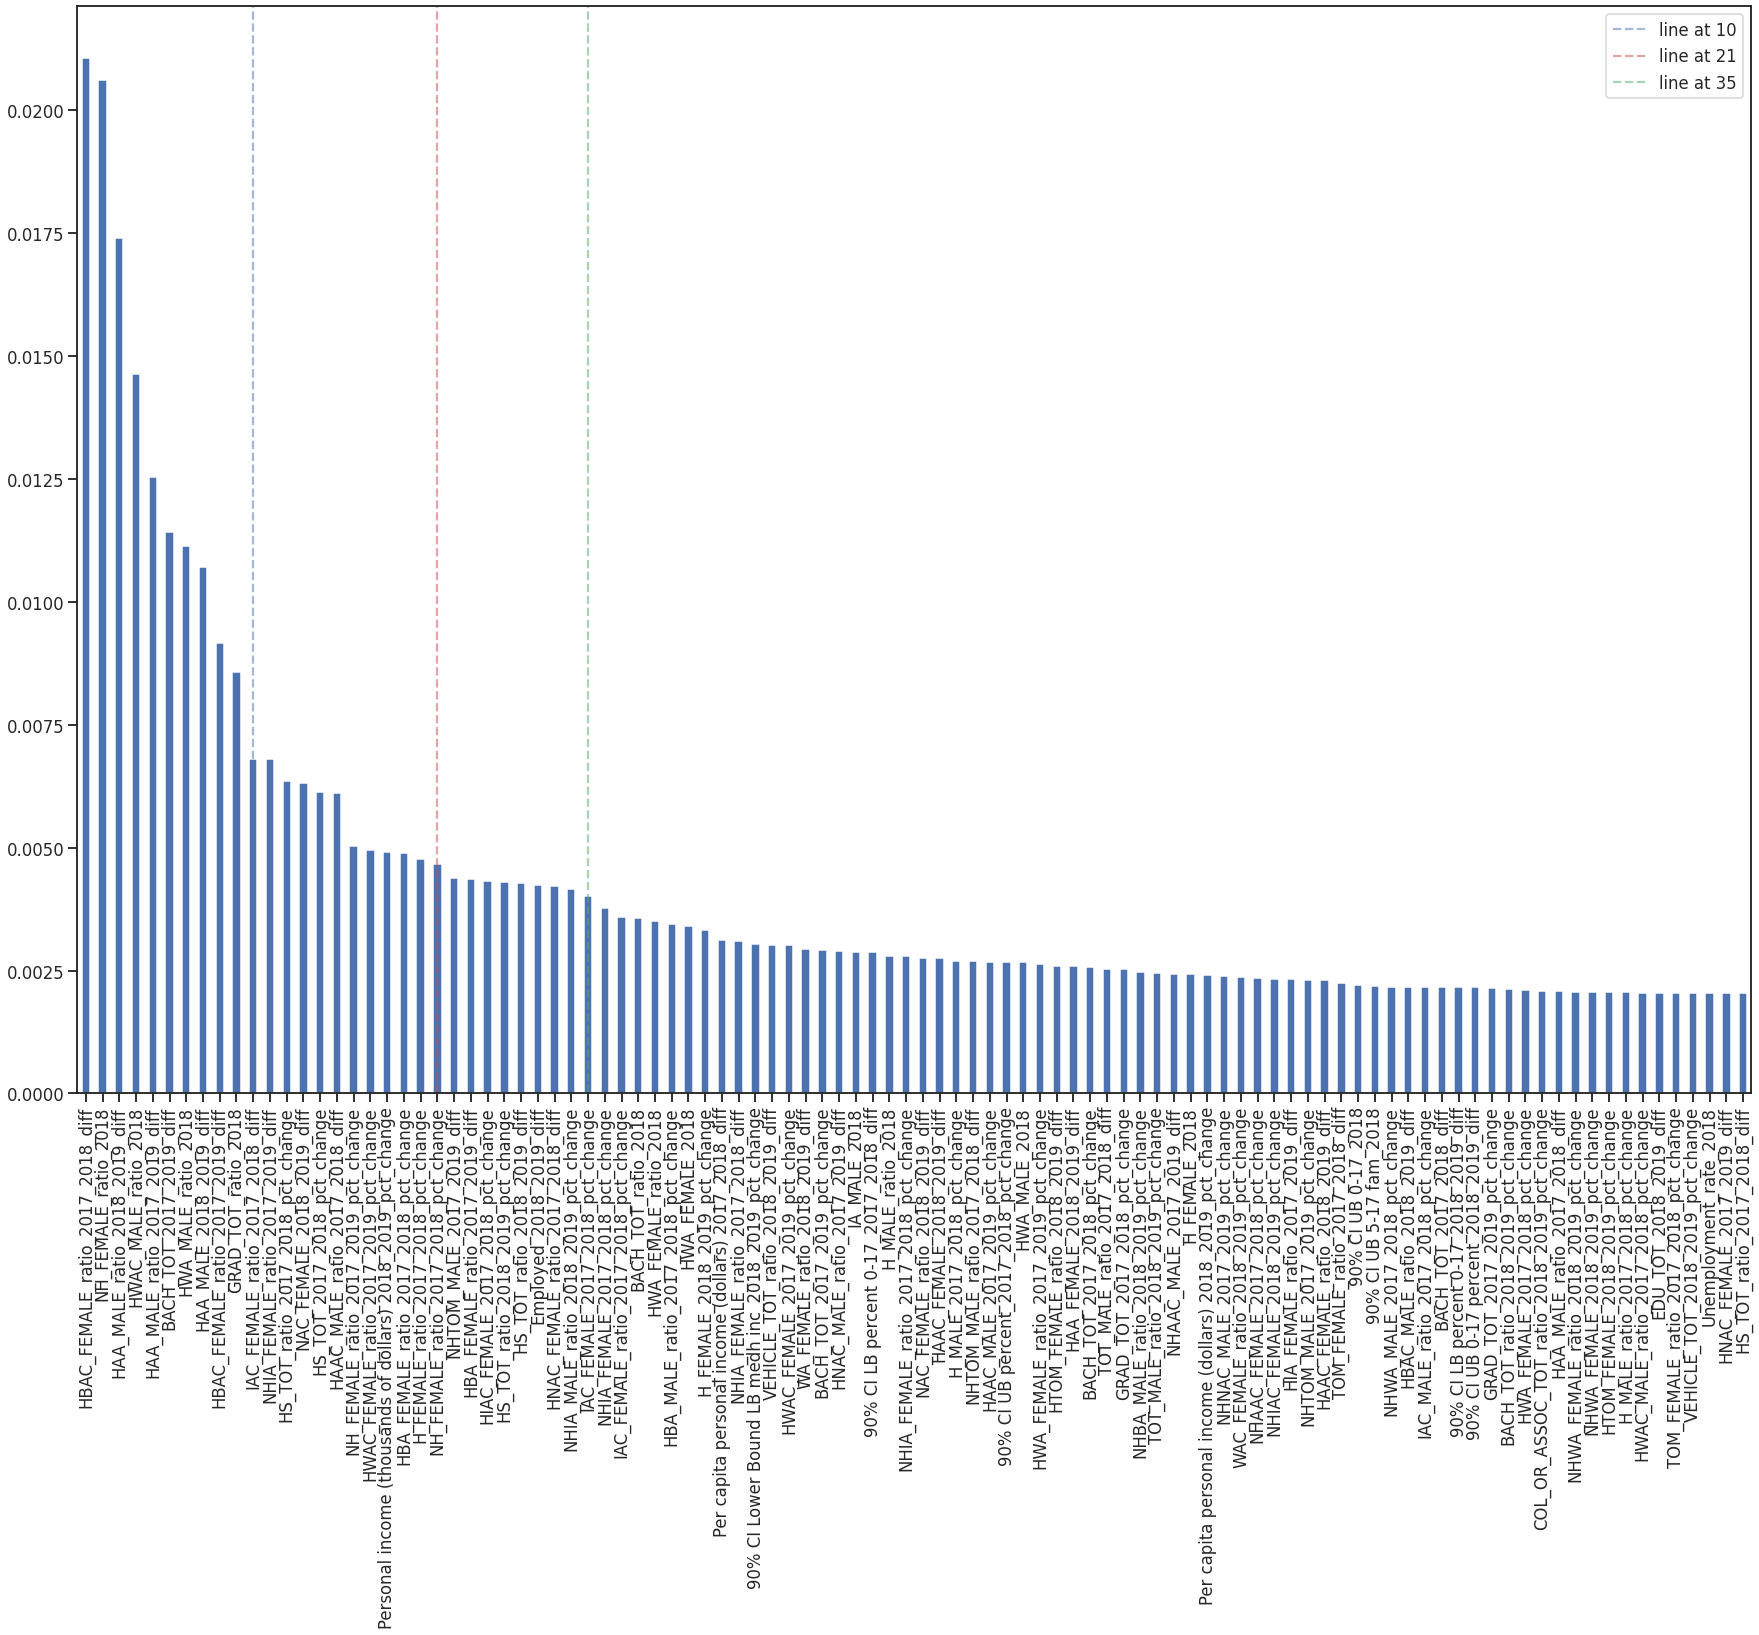

In [81]:
plt.figure(figsize=(30,20))
plt.axvline(x=10, c='b', ls='--', alpha=.5, label='line at 10')
plt.axvline(x=21, c='r', ls='--', alpha=.5, label='line at 21')
plt.axvline(x=30, c='g', ls='--', alpha=.5, label='line at 35')
plt.legend()
rf_feat_importances[:100].plot(kind='bar')

In [69]:
rf_feat_importances[:20]

HBAC_FEMALE_ratio_2017_2018_diff                               0.021064
NH_FEMALE_ratio_2018                                           0.020616
HAA_MALE_ratio_2018_2019_diff                                  0.017405
HWAC_MALE_ratio_2018                                           0.014636
HAA_MALE_ratio_2017_2019_diff                                  0.012532
BACH_TOT_2017_2019_diff                                        0.011422
HWA_MALE_ratio_2018                                            0.011146
HAA_MALE_2018_2019_diff                                        0.010718
HBAC_FEMALE_ratio_2017_2019_diff                               0.009172
GRAD_TOT_ratio_2018                                            0.008567
IAC_FEMALE_ratio_2017_2018_diff                                0.006813
NHIA_FEMALE_ratio_2017_2019_diff                               0.006795
HS_TOT_ratio_2017_2018_pct_change                              0.006357
NAC_FEMALE_2018_2019_diff                                      0

### Evaluation of graph
It appears that the importance for features is very small with 0.02 being the largest feature important.
The top 10 features are
* HBAC_FEMALE_ratio_2017_2018_diff    0.021064
* NH_FEMALE_ratio_2018                0.020616
* HAA_MALE_ratio_2018_2019_diff       0.017405
* HWAC_MALE_ratio_2018                0.014636
* HAA_MALE_ratio_2017_2019_diff       0.012532
* BACH_TOT_2017_2019_diff             0.011422
* HWA_MALE_ratio_2018                 0.011146
* HAA_MALE_2018_2019_diff             0.010718
* HBAC_FEMALE_ratio_2017_2019_diff    0.009172
* GRAD_TOT_ratio_2018
And they appear to be the majority feature importances
With the feature importance starting to converge at 25-30 features

In [83]:
rf_best_pipe = rf_grid_cv.best_estimator_
rf_best_pipe.fit(X_train,y_train)
rf_best_pipe.score(X_test, y_test)


0.30815356080600176

In [86]:
print('train score', rf_grid_cv.best_score_)
print('train std', rf_grid_cv.cv_results_['std_test_score'][rf_grid_cv.best_index_])
print('test score', rf_best_pipe.score(X_test, y_test))

train score 0.2879457411778487
train std 0.1506202031809065
test score 0.30815356080600176


### Evaluation of train and test scores (r2)
This appears to be an appropriate evaluation as .3 is within 1 standard deviation of our train score

## Random Forest Regressor Model (Using 21 top important features)
* Using 21 features that scored largest in feature importance from previous Random Forest Regressor model that had used all 1311 featues

In [21]:
# 21 most important features
rf_feat_importances = ['HBAC_FEMALE_ratio_2017_2018_diff',
'NH_FEMALE_ratio_2018',
'HAA_MALE_ratio_2018_2019_diff',
'HWAC_MALE_ratio_2018',
'HAA_MALE_ratio_2017_2019_diff',
'BACH_TOT_2017_2019_diff',
'HWA_MALE_ratio_2018',
'HAA_MALE_2018_2019_diff',
'HBAC_FEMALE_ratio_2017_2019_diff',
'GRAD_TOT_ratio_2018',
'IAC_FEMALE_ratio_2017_2018_diff',
'NHIA_FEMALE_ratio_2017_2019_diff',
'HS_TOT_ratio_2017_2018_pct_change',
'NAC_FEMALE_2018_2019_diff',
'HS_TOT_2017_2018_pct_change',
'HAAC_MALE_ratio_2017_2018_diff',
'NH_FEMALE_ratio_2017_2019_pct_change',
'HWAC_FEMALE_ratio_2017_2019_pct_change',
'Personal income (thousands of dollars) 2018_2019_pct_change',
'HBA_FEMALE_ratio_2017_2018_pct_change',
'H_FEMALE_ratio_2017_2018_pct_change']

In [22]:
# Commented code cannot be reproducible as best columns were retreived from randomized grid search with no random state
# rf_important_feats_for_columns = rf_feat_importances.index[:21].tolist()
# rf_important_feats_for_columns
# X_train_rf_imp_feat = X_train[rf_important_feats_for_columns]
# X_test_rf_imp_feat = X_test[rf_important_feats_for_columns]


# tru model with 21 features (using saved best features from past randomized grid search)
rf_important_feats_for_columns = rf_feat_importances
rf_important_feats_for_columns
X_train_rf_imp_feat = X_train[rf_important_feats_for_columns]
X_test_rf_imp_feat = X_test[rf_important_feats_for_columns]


In [25]:
rf_best_feat_pipe = Pipeline([('rf', RandomForestRegressor(random_state=42, criterion='mae'))])
rf_best_feat_param_grid = {'rf__n_estimators': np.arange(1,250),
                           'rf__ccp_alpha': np.arange(0, 1, step=0.1)}

In [118]:

rf_best_feat_grid = GridSearchCV(rf_best_feat_pipe, param_grid=rf_best_feat_param_grid, cv=5, n_jobs=-1)
rf_best_feat_grid.fit(X_train_rf_imp_feat, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestRegressor(criterion='mae',
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__ccp_alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'rf__n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  4...
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217,

In [134]:
rf_best_feat_grid.best_params_

{'rf__ccp_alpha': 0.0, 'rf__n_estimators': 221}

In [121]:
rf_best_feat_grid.best_score_

0.4065410028335659

In [122]:
rf_best_feat_mean_score = rf_best_feat_grid.cv_results_['mean_test_score']
rf_best_feat_std_score = rf_best_feat_grid.cv_results_['std_test_score']
rf_best_feat_n_estimators_for_grid = [n for n in rf_best_feat_grid.cv_results_['param_rf__n_estimators']]

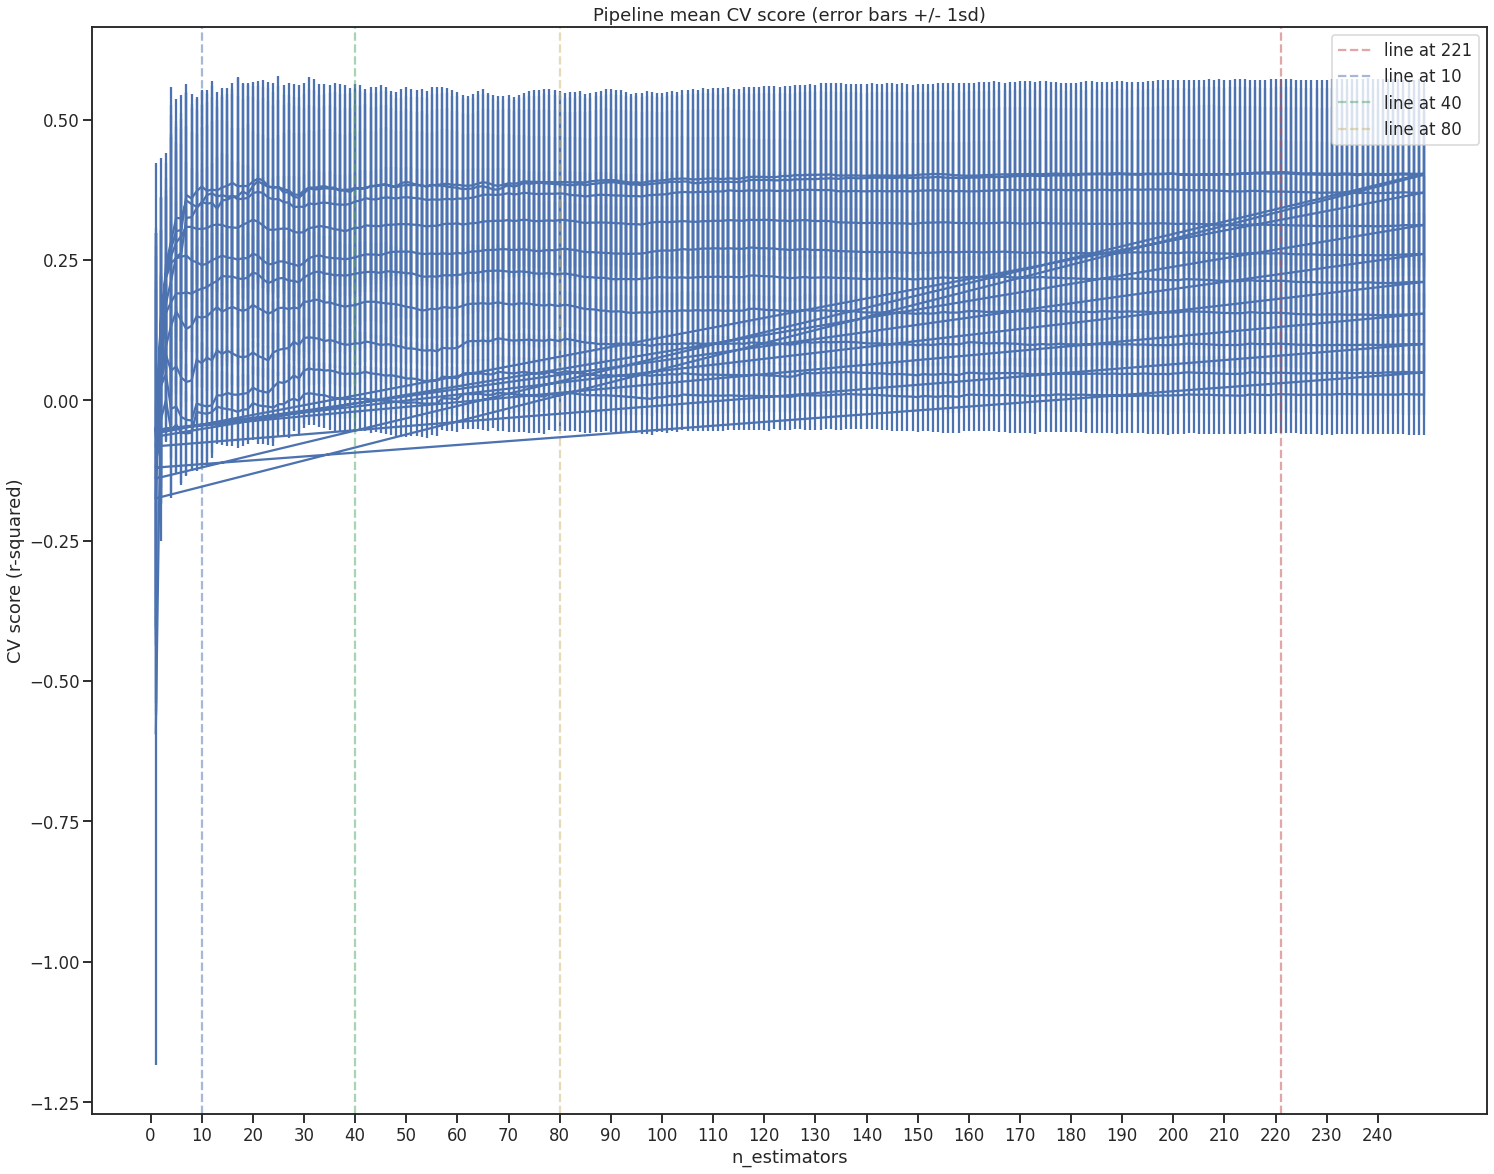

In [131]:
plt.subplots(figsize=(25, 20))
plt.errorbar(rf_best_feat_n_estimators_for_grid, rf_best_feat_mean_score, yerr=rf_best_feat_std_score)
plt.axvline(x=rf_best_feat_grid.best_params_['rf__n_estimators'], c='r', ls='--', alpha=.5, label='line at 221')
plt.axvline(x=10, c='b', ls='--', alpha=.5, label='line at 10')
plt.axvline(x=40, c='g', ls='--', alpha=.5, label='line at 40')
plt.axvline(x=80, c='y', ls='--', alpha=.5, label='line at 80')
plt.xticks(np.arange(0,250, step=10))
plt.xlabel('n_estimators')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')
plt.legend();

### Graph relationship between n_estimators and mean CV scores
* Each solid blue line represent mean CV scores using different hyperparameters
* Vertical bars represent variation associated for each CV score


In [133]:
rf_best_feat_pipe = rf_best_feat_grid.best_estimator_
rf_best_feat_pipe.fit(X_train_rf_imp_feat, y_train)
rf_best_feat_pipe.score(X_test_rf_imp_feat, y_test)

0.4037547099524138

### Evaluation of graph
It appears that this the r2 score drasticlly increase from 0 - 10
and additional addition of estimators does not appear to increase the score
the variance appears to be smallest from range 40-50 but the variance overall seems relatively
the same from 10 to 250

In [138]:
# look at feawture importance
feat_importances = rf_best_feat_grid.best_estimator_.named_steps.rf.feature_importances_
rf_feat_importances = pd.Series(feat_importances, index=X_train_rf_imp_feat.columns).sort_values(ascending=False)
rf_feat_importances.head(10)

BACH_TOT_2017_2019_diff                                        0.072646
HAA_MALE_ratio_2018_2019_diff                                  0.070659
HBAC_FEMALE_ratio_2017_2018_diff                               0.066875
IAC_FEMALE_ratio_2017_2018_diff                                0.059033
HBAC_FEMALE_ratio_2017_2019_diff                               0.056135
HS_TOT_2017_2018_pct_change                                    0.055338
NHIA_FEMALE_ratio_2017_2019_diff                               0.055242
Personal income (thousands of dollars) 2018_2019_pct_change    0.055009
HAA_MALE_ratio_2017_2019_diff                                  0.054966
HS_TOT_ratio_2017_2018_pct_change                              0.045067
dtype: float64

### Graph top scored important features
* Usage of 21 features (same number used to train this model)

<AxesSubplot:>

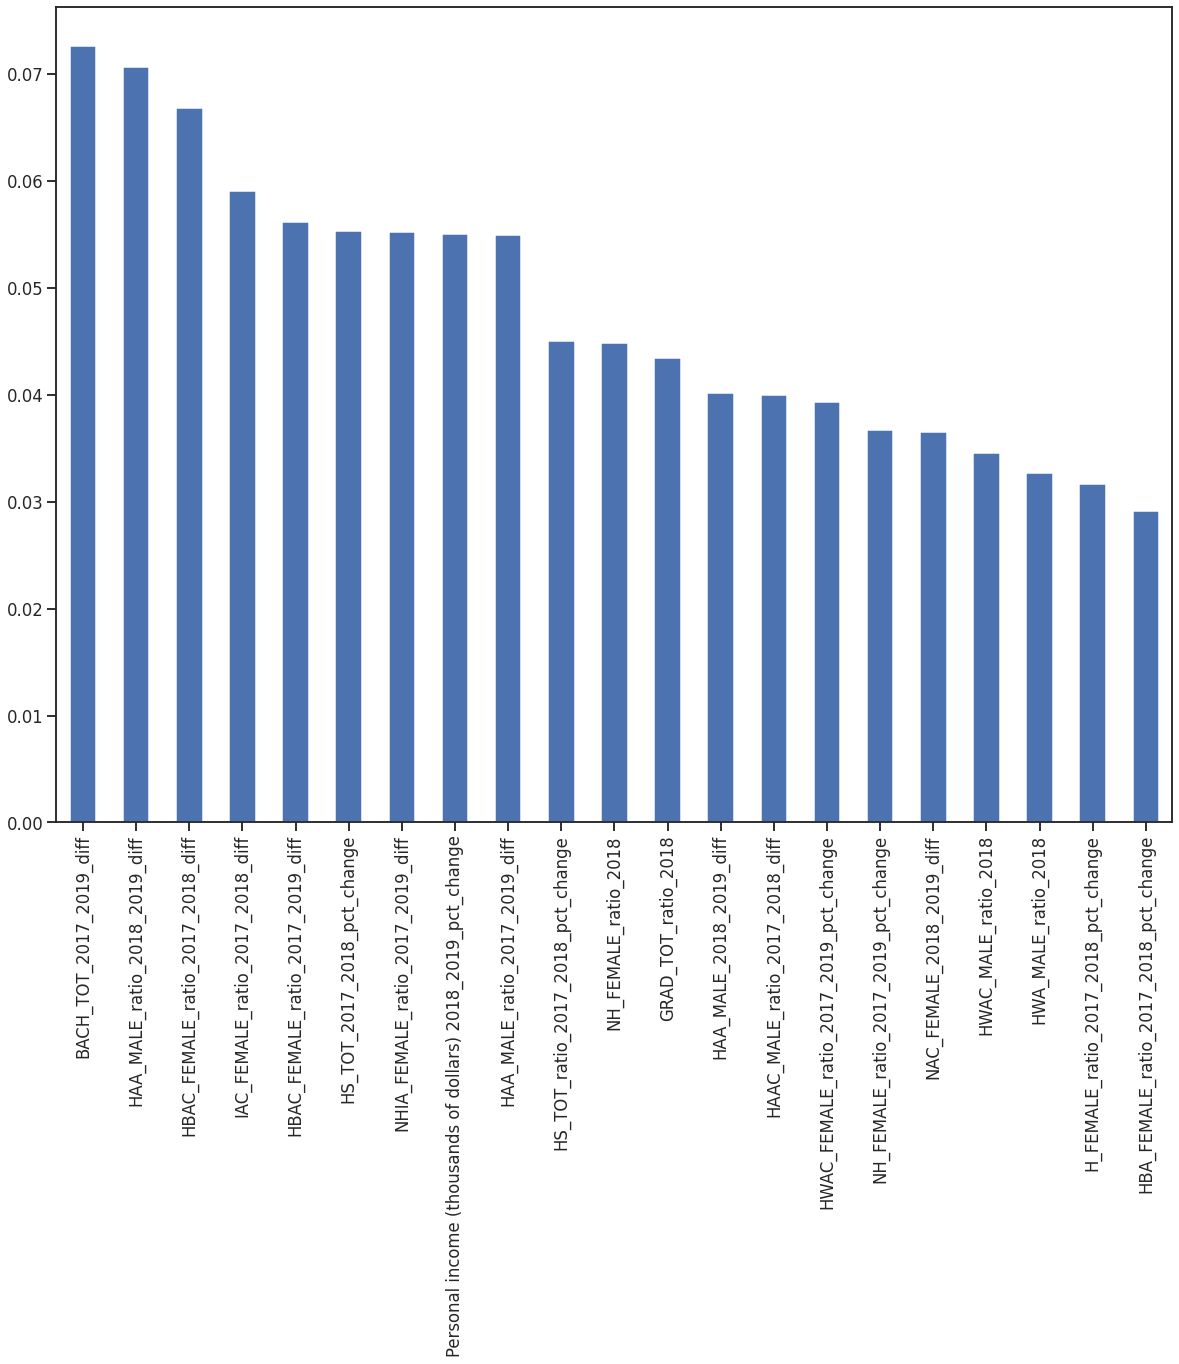

In [141]:
plt.figure(figsize=(20,15))
rf_feat_importances.plot(kind='bar')

In [142]:
rf_feat_importances

BACH_TOT_2017_2019_diff                                        0.072646
HAA_MALE_ratio_2018_2019_diff                                  0.070659
HBAC_FEMALE_ratio_2017_2018_diff                               0.066875
IAC_FEMALE_ratio_2017_2018_diff                                0.059033
HBAC_FEMALE_ratio_2017_2019_diff                               0.056135
HS_TOT_2017_2018_pct_change                                    0.055338
NHIA_FEMALE_ratio_2017_2019_diff                               0.055242
Personal income (thousands of dollars) 2018_2019_pct_change    0.055009
HAA_MALE_ratio_2017_2019_diff                                  0.054966
HS_TOT_ratio_2017_2018_pct_change                              0.045067
NH_FEMALE_ratio_2018                                           0.044850
GRAD_TOT_ratio_2018                                            0.043479
HAA_MALE_2018_2019_diff                                        0.040214
HAAC_MALE_ratio_2017_2018_diff                                 0

In [137]:
print('train score', rf_best_feat_grid.best_score_)
print('train std deviation', rf_best_feat_grid.cv_results_['std_test_score'][rf_best_feat_grid.best_index_])
print('test score', rf_best_feat_pipe.score(X_test_rf_imp_feat, y_test))

train score 0.4065410028335659
train std deviation 0.16553799714480133
test score 0.4037547099524138


### Evaluation of train and test score (r2)
This test score seems highly plausible as it is within 1 standard deviation from the train score. Only 0.003 difference between train and test score.

# Model Evaluations
* Linear Regression
* Random Forest Regressor (use all features)
* Random Forest Regressor (usage of 21 features from top score feature importances from previous model)

In [ ]:
# linear regression

## Linear Regression Model
## (Cross Validated train scores vs test score)

In [184]:
print('Train MAE mean:', lr_mae_mean, 'CV Train Std', lr_mae_std)
print('Test MAE mean:', lr_mae_test_mean)
print('\n')
print('Train R^2:', lr_best_mean, 'Train std', lr_best_std)
print('Test R^2:', best_lr_pipe.score(X_test, y_test))
print('\nNumber of features:', len(lr_features))
pd.Series(coefs, index=lr_features).sort_values(ascending=False)

Train MAE mean: 3.524905303808373 CV Train Std 0.47942535483907917
Test MAE mean: 3.1819736651067734


Train R^2: 0.26496610736212933 Train std 0.11753944354754035
Test R^2: 0.4063704301457888

Number of features: 3


HWAC_MALE_ratio_2018    17.546961
HWA_MALE_ratio_2018     -3.238566
H_MALE_ratio_2018      -11.785481
dtype: float64

## Random Forest Regressor
## (Cross Validated train scores vs test score)

In [177]:
rf_neg_mae = cross_validate(rf_grid.best_estimator_, X_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [192]:
rf_mae_mean = -1 * np.mean(rf_neg_mae['test_score'])
rf_mae_std = -1 * np.std(rf_neg_mae['test_score'])
rf_mae_test_mean = mean_absolute_error(y_test, rf_grid.best_estimator_.predict(X_test))

rf_train_score = rf_grid.best_score_
rf_train_std = rf_grid.cv_results_['std_test_score'][rf_grid.best_index_]
rf_test_score = rf_grid.score(X_test, y_test)

In [193]:
print('Train MAE mean:', rf_mae_mean, 'CV Train Std', rf_mae_std)
print('Test MAE mean:', rf_mae_test_mean)
print('\n')
print('Train R^2:', rf_train_score, 'Train std', rf_train_std)
print('Test R^2:', rf_test_score)
print('\nNumber of features:', len(X_train.columns))
rf_feat_imp.head(10)

Train MAE mean: 3.3794073719446827 CV Train Std -0.5735764824922404
Test MAE mean: 3.585880939300005


Train R^2: 0.2653864689058124 Train std 0.1515902486506784
Test R^2: 0.34447588520907024

Number of features: 1311


HBAC_FEMALE_ratio_2017_2018_diff    0.021064
NH_FEMALE_ratio_2018                0.020616
HAA_MALE_ratio_2018_2019_diff       0.017405
HWAC_MALE_ratio_2018                0.014636
HAA_MALE_ratio_2017_2019_diff       0.012532
BACH_TOT_2017_2019_diff             0.011422
HWA_MALE_ratio_2018                 0.011146
HAA_MALE_2018_2019_diff             0.010718
HBAC_FEMALE_ratio_2017_2019_diff    0.009172
GRAD_TOT_ratio_2018                 0.008567
dtype: float64

## Random Forest Regressor with top important features
## (Cross Validated train scores vs test score)

In [194]:
rf_best_feat_mae = cross_validate(rf_best_feat_grid.best_estimator_, X_train_rf_imp_feat, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [196]:
rf_best_feat_mae_mean = -1 * np.mean(rf_best_feat_mae['test_score'])
rf_best_feat_mae_std = -1 * np.std(rf_best_feat_mae['test_score'])
rf_best_feat_mae_test_mean = mean_absolute_error(y_test, rf_best_feat_grid.best_estimator_.predict(X_test_rf_imp_feat))
rf_best_feat_train_score = rf_best_feat_grid.best_score_
rf_best_feat_train_std = rf_best_feat_grid.cv_results_['std_test_score'][rf_best_feat_grid.best_index_]
rf_best_feat_test_score = rf_best_feat_grid.score(X_test_rf_imp_feat, y_test)

In [198]:
print('Train MAE mean:', rf_best_feat_mae_mean, 'CV Train Std', rf_best_feat_mae_std)
print('Test MAE mean:', rf_best_feat_mae_test_mean)
print('\n')
print('Train R^2:', rf_best_feat_train_score, 'Train std', rf_best_feat_train_std)
print('Test R^2:', rf_best_feat_test_score)
print('\nNumber of features:', len(X_train_rf_imp_feat.columns))
rf_feat_importances.head(10)


Train MAE mean: 2.9925311384985127 CV Train Std -0.4658950227550414
Test MAE mean: 3.511801495223753


Train R^2: 0.4065410028335659 Train std 0.16553799714480133
Test R^2: 0.4037547099524138

Number of features: 21


BACH_TOT_2017_2019_diff                                        0.072646
HAA_MALE_ratio_2018_2019_diff                                  0.070659
HBAC_FEMALE_ratio_2017_2018_diff                               0.066875
IAC_FEMALE_ratio_2017_2018_diff                                0.059033
HBAC_FEMALE_ratio_2017_2019_diff                               0.056135
HS_TOT_2017_2018_pct_change                                    0.055338
NHIA_FEMALE_ratio_2017_2019_diff                               0.055242
Personal income (thousands of dollars) 2018_2019_pct_change    0.055009
HAA_MALE_ratio_2017_2019_diff                                  0.054966
HS_TOT_ratio_2017_2018_pct_change                              0.045067
dtype: float64

In comparison with mean and median dummy regressors

In [261]:
print('Using Mean Strategy:')
print('Train MAE mean:', dummy_mean_mae, 'CV Train Std', dummy_mean_mae_std)
print('Test MAE mean:', dummy_mean_mae_test)
print('\n')
print('Train R^2:', dummy_mean_train_score, 'Train std', dummy_mean_train_std)
print('Test R^2:', dummy_mean_test_score)
print('\n')
print('Using Median Strategy:')
print('Train MAE mean:', dummy_median_mae, 'CV Train Std', dummy_median_mae_std)
print('Test MAE mean:', dummy_median_mae_test)
print('\n')
print('Train R^2:', dummy_median_train_score, 'Train std', dummy_median_train_std)
print('Test R^2:', dummy_median_test_score)

Using Mean Strategy:
Train MAE mean: -2.859319876514479 CV Train Std 0.4915346089757947
Test MAE mean: 4.224395075447405


Train R^2: -0.01988083053185279 Train std 0.015606963641777855
Test R^2: -0.014683484428373195


Using Median Strategy:
Train MAE mean: -2.859319876514479 CV Train Std 0.4915346089757947
Test MAE mean: 3.965553703522264


Train R^2: -0.05634349921670236 Train std 0.0770498421567673
Test R^2: -0.005731197263146637


## Evaluation of models
From looking at all 3 models it appears that either Random Forest Regressor with top important features or Linear Regression model performed best.
Whereas Random Forest Regressor with top features seems to have a 0.4 coefficient of determination and low variance with the score, the Linear Regression
model performs just as well with a .4 coefficient of determination however the variance for this score appears higher being within just 2 standard deviations from
the train score.

Although the Random Forest model with top important features performs as well and has less variance than Linear Regression model, the Linear Regression is simpler
in terms of using only 3 features to explain the variation in our target feature AQI_2019, whereas our ensemble model uses 21 features. Also it appears that Linear Regression
appears slightly better in having a MAE with 3.1 in comparison to our ensemble model with 3.5; but once again the variance for the Linear Regression model appears high, and the
variance for a 3.5 score with our ensemble model appears unlikely as it is over 2 standard deviations from our mean train score.

Overall the Random Forest Regressor with top important features model appears to be most suitable, as it is both low variable and has same strength as Linear Regression Model. Our
regular Random Forest Regressor model, however is our worst model with inefficiency of using 1311 features and performing the worst out of the two.

Last in comparison with dummy regresors, our selected models perform much better with a r^2 of around 0.4 whereas the dummy regressors produce -0.01 r^2 score, which is a significant
improvement

n.b. (The parameters for the Random Forest Regressors show that none scaling yielded best results)

## save models

In [215]:
rf_best_feat_model = rf_best_feat_grid.best_estimator_
rf_best_feat_model.version = '1.0'
rf_best_feat_model.pandas_version = pd.__version__
rf_best_feat_model.numpy_version = np.__version__
rf_best_feat_model.sklearn_version = sklearn_version
rf_best_feat_model.X_columns = [col for col in X_train_rf_imp_feat.columns]
rf_best_feat_model.build_datetime = datetime.datetime.now()

In [216]:
# Save rf_best_feat_model
model_path = r'../../model/rf_best_feat_model.sav'
joblib.dump(rf_best_feat_model, model_path)

['../../model/rf_best_feat_model.sav']

In [223]:
# Save linear regression model
lr_model = lr_grid.best_estimator_
lr_model.version = '1.0'
lr_model.pandas_version = pd.__version__
lr_model.numpy_version = np.__version__
lr_model.sklearn_version = sklearn_version
lr_model.X_columns = [col for col in lr_features]
lr_model.build_datetime = datetime.datetime.now()

In [224]:
# Save lr_model
model_path = r'../../model/lr_model.sav'
joblib.dump(lr_model, model_path)

['../../model/lr_model.sav']

In [ ]:
rf_best_feat_pipe = rf_best_feat_grid.best_estimator_
rf_best_feat_pipe.fit(X_train_rf_imp_feat, y_train)
rf_best_feat_pipe.score(X_test_rf_imp_feat, y_test)

In [29]:
model_path = r'../../model/rf_best_feat_model_2.sav'
joblib.dump(rf_best_feat_pipe, model_path)



['../../model/rf_best_feat_model_2.sav']